In [2]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Custom Functions

In [3]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig
        

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [6]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [7]:
df = pd.read_csv('C:/Users/Dell/Downloads/opsd_germany_daily.csv')
df.head(5)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


### Convert the Date column to datetime and make it the index

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

### Resample the data to a monthly frequency calculated with the mean

In [9]:
df = df.resample('M').mean()

### We will look at the "Consumption" column for our time series

In [10]:
ts = df['Consumption']

### Check for and address missing values

In [11]:
ts.isna().sum()

0

### Plot the time series

<Axes: xlabel='Date'>

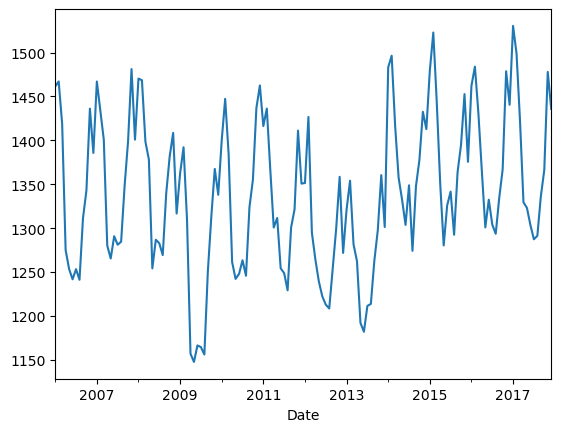

In [12]:
ts.plot()

# ARIMA

### Use ndiffs to determine if nonseasonal differencing is required

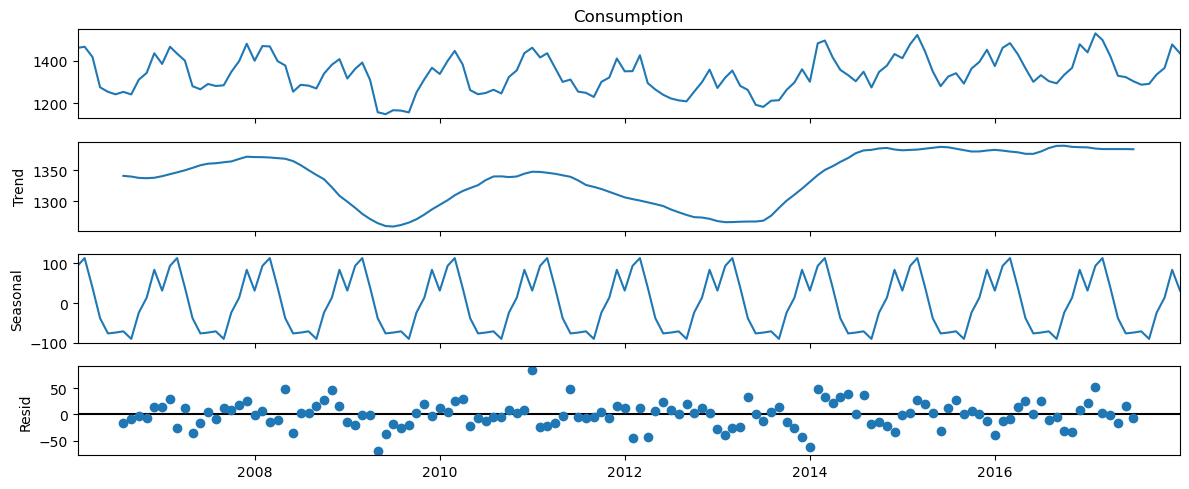

In [13]:
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [14]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 202.81993893058794 which is ~52.99% of the variation in time series.


In [15]:
ndiffs(ts)

0

In [16]:
nsdiffs(ts, m = 12)

0

### Plot ACF and PACF to estimate initial orders

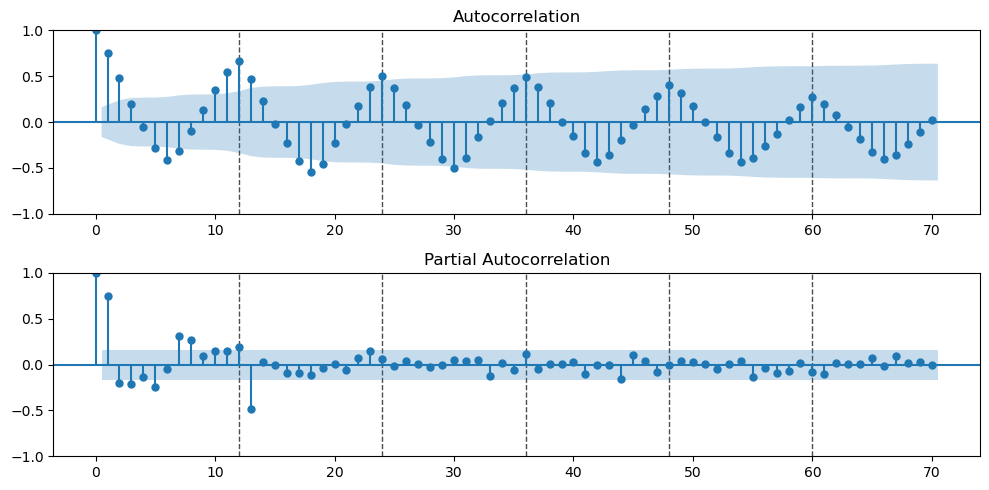

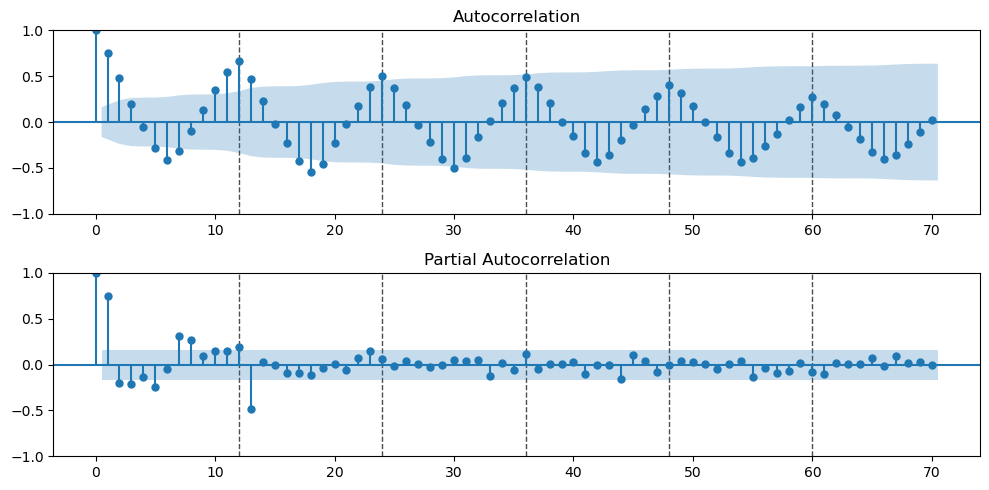

In [17]:
plot_acf_pacf(ts, annotate_seas=True, m = 12, nlags = 70)

### Train test split the data using a test_size equal to the length of the final forecast (24 months) and visualize the result

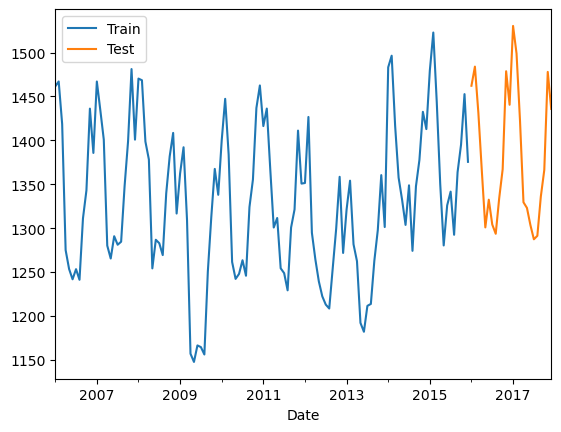

In [18]:
test_lags = 24 
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### ARIMA Model

In [19]:
p = 1  
d = 0  
q = 0  
arima = tsa.ARIMA(train, order = (p,d,q)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -653.886
Date:                Mon, 17 Jun 2024   AIC                           1313.773
Time:                        20:45:57   BIC                           1322.135
Sample:                    01-31-2006   HQIC                          1317.169
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1334.9675     20.412     65.401      0.000    1294.961    1374.974
ar.L1          0.7558      0.074     10.171      0.000       0.610       0.901
sigma2      3143.5981    412.704      7.617      0.000    2334.713    3952.484
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.12   Prob(JB):                         0.99
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

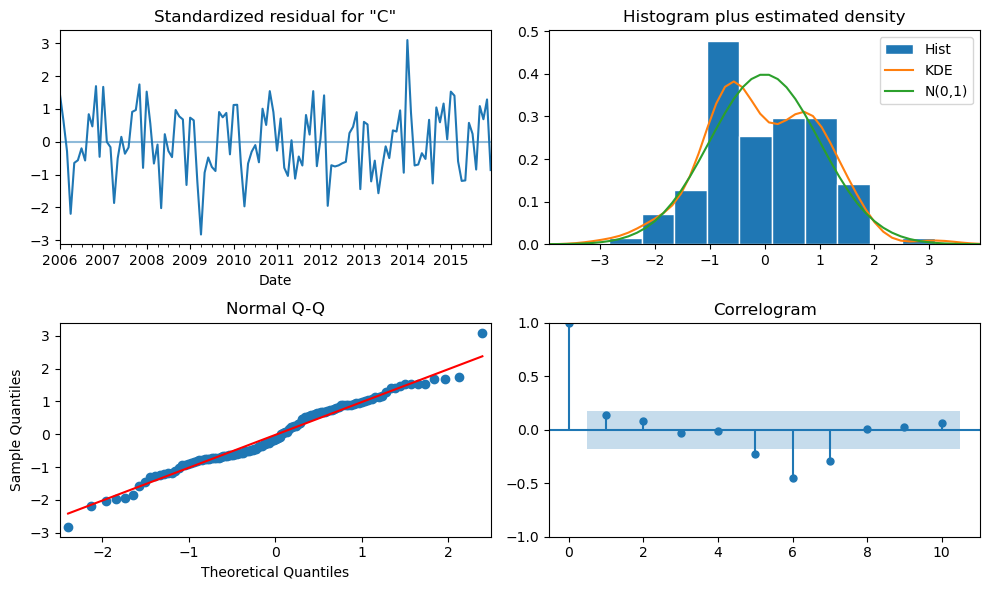

In [20]:
fig = arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.492
- MSE = 7,412.715
- RMSE = 86.097
- R^2 = -0.279
- MAPE = 4.63%


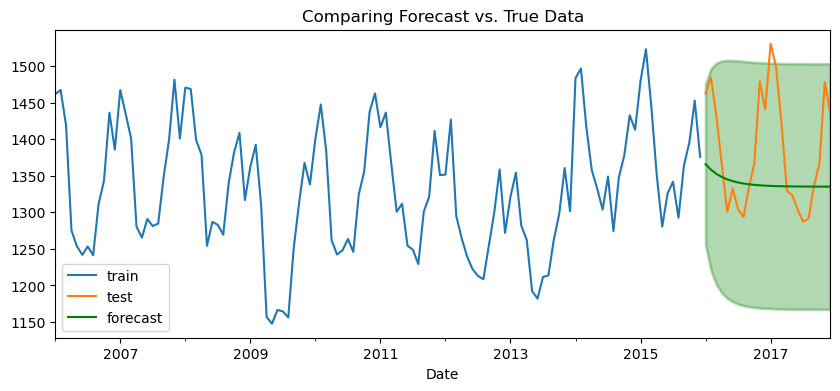

In [21]:
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

# SARIMA

### Use nsdiffs to determine if seasonal differencing is required

In [22]:
d = ndiffs(ts)
print (f'd = {d}')

d = 0


Seasonal differencing is not required

### SARIMA Model

In [23]:
p = 1  
d = 0  
q = 0  

P = 1  
D = 0  
Q = 1  
m = 12 

In [24]:
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [25]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Mon, 17 Jun 2024   AIC                           1215.739
Time:                                    20:46:01   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7488     57.829     23.012      0.000    1217.406    1444.092
ar.L1          0.7879      0.058     13.540      0.000       0.674       0.902
ar.S.L12       0.9954      0.011     92.027      0.000       0.974       1.017
ma.S.L12      -0.8626      0.158     -5.470      0.000      -1.172      -0.554
sigma2      1088.1793    202.165      5.383      0.000     691.942    1484.416
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                23.61
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

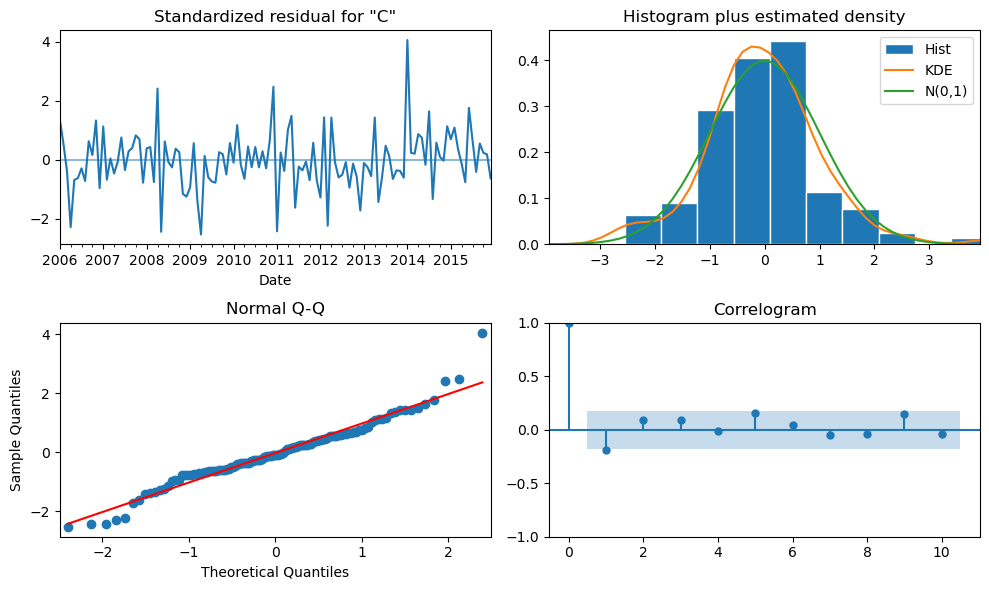

In [26]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.262
- MSE = 2,690.161
- RMSE = 51.867
- R^2 = 0.536
- MAPE = 3.30%


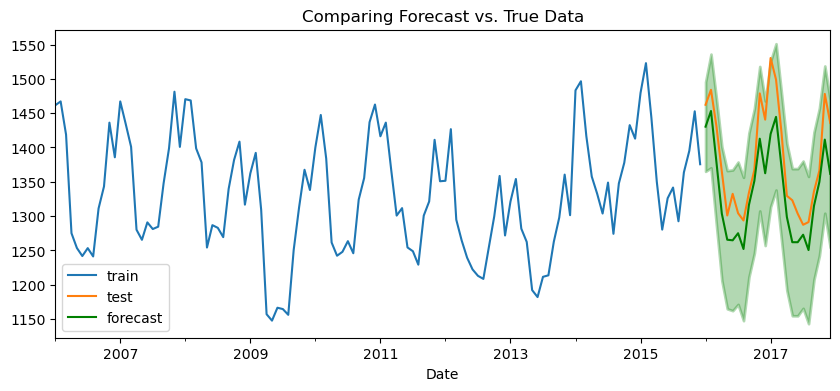

In [27]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

The model performs very well 

adding a seasonal component will improve the AIC Score. 

# Grid Search Assignement

### Autoarrima Model

In [28]:
import pmdarima as pm

auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1250.337, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1411.678, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1264.720, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1303.150, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2069.451, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1251.753, Time=1.86 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1250.745, Time=1.81 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=1254.501, Time=0.86 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=1262.4

In [29]:
print(auto_model.order)
print(auto_model.seasonal_order)

(2, 0, 2)
(1, 0, 1, 12)


In [30]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 2 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

C:\Users\Dell\anaconda3_v1\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -598.029
Date:                            Mon, 17 Jun 2024   AIC                           1212.059
Time:                                    20:48:28   BIC                           1234.359
Sample:                                01-31-2006   HQIC                          1221.115
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.5414     28.197     47.188      0.000    1275.277    1385.806
ar.L1          1.8773      0.123     15.280      0.000       1.636       2.118
ar.L2         -0.8831      0.117     -7.569      0.000      -1.112      -0.654
ma.L1         -1.3364      0.672     -1.989      0.047      -2.653      -0.020
ma.L2          0.3395      0.310      1.096      0.273      -0.268       0.947
ar.S.L12       0.9946      0.012     79.853      0.000       0.970       1.019
ma.S.L12      -0.8311      0.195     -4.255      0.000      -1.214      -0.448
sigma2      1213.5819    622.491      1.950      0.051      -6.479    2433.643
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.48
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.59
Prob(H) (two-sided):                  0.90   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 53.332
- MSE = 3,486.880
- RMSE = 59.050
- R^2 = 0.398
- MAPE = 3.82%


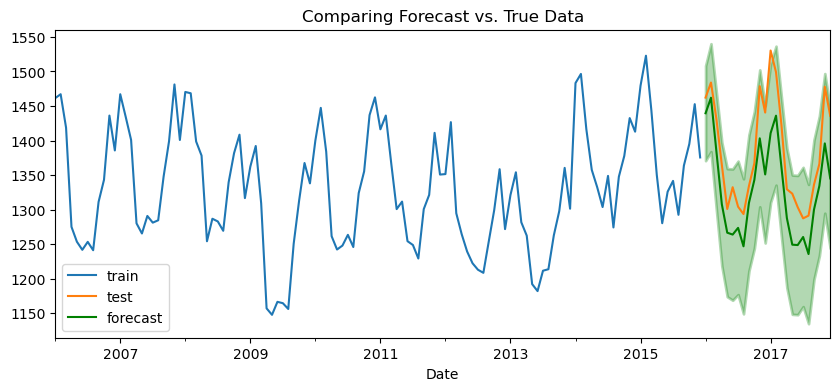

In [32]:
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

The First regression Metrics are for the intial model Sarima(1,0,0), the second one is for the auto model, autoarima(2,0,2)

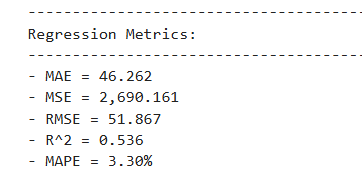   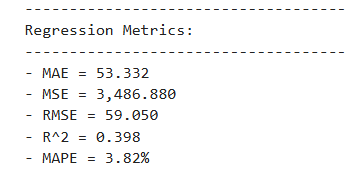

The Initial Model performs better that the auto model but both of them performs slightly well. 